In [ ]:
import ira
import seaborn as sns
from sklearn import linear_model
from ira.analysis.kalman import kalman_regression_estimator, add_constant

%alphalab dark
from alpha.utils.stat_helpers import cmp_to_norm

# Tracking Russell 1000 index
<hr/>

Take a look at structure of Russel 1000 index constituents (from file at https://www.ishares.com/us/products/239708/ishares-russell-1000-value-etf)

In [1164]:
holdings = pd.read_csv('../data/IWD_holdings.csv').dropna()
holdings = holdings.sort_values('Weight (%)', ascending=False)

holdings

,Ticker,Name,Asset Class,Weight (%),Price,Shares,Market Value,Notional Value,Sector,SEDOL,ISIN,Exchange
0,BRKB,BERKSHIRE HATHAWAY INC CLASS B,Equity,3.07,226.50,"5,773,842.00","1,307,775,213.00","1,307,775,213.00",Financials,2073390,US0846707026,New York Stock Exchange Inc.
1,JPM,JPMORGAN CHASE & CO,Equity,3.01,139.40,"9,203,480.00","1,282,965,112.00","1,282,965,112.00",Financials,2190385,US46625H1005,New York Stock Exchange Inc.
2,JNJ,JOHNSON & JOHNSON,Equity,2.28,145.87,"6,655,914.00","970,898,175.18","970,898,175.18",Health Care,2475833,US4781601046,New York Stock Exchange Inc.
3,XOM,EXXON MOBIL CORP,Equity,2.04,69.78,"12,492,575.00","871,731,883.50","871,731,883.50",Energy,2326618,US30231G1022,New York Stock Exchange Inc.
4,PG,PROCTER & GAMBLE,Equity,2.01,124.90,"6,871,540.00","858,255,346.00","858,255,346.00",Consumer Staples,2704407,US7427181091,New York Stock Exchange Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...
745,LENB,LENNAR CORP CLASS B,Equity,0.00,44.70,"32,766.00","1,464,640.20","1,464,640.20",Consumer Discretionary,2578293,US5260573028,New York Stock Exchange Inc.
746,PII,POLARIS INDUSTRIES INC,Equity,0.00,101.70,"13,436.00","1,366,441.20","1,366,441.20",Consumer Discretionary,2692933,US7310681025,New York Stock Exchange Inc.
747,IAA,IAA INC,Equity,0.00,47.06,"28,227.00","1,328,362.62","1,328,362.62",Industrials,BJF8Q81,US4492531037,New York Stock Exchange Inc.
748,SWI,SOLARWINDS CORP,Equity,0.00,18.55,"71,678.00","1,329,626.90","1,329,626.90",Information Technology,BG1VY34,US83417Q1058,New York Stock Exchange Inc.


In [1165]:
# taking first 50 ones with most significant weights
Nc = 50
constituents = holdings.Ticker[:Nc].values

interval = ('2016-01-01', '2020-07-01')
dsrc = {c:z_load('stocks::%s_daily' % c)['data'] for c in np.append(constituents, 'RUI')}

data = retain_columns_and_join(dsrc, 'close').fillna(method='ffill').dropna()[slice(*interval)]
RUI = data['RUI']
data = data.drop(columns='RUI')

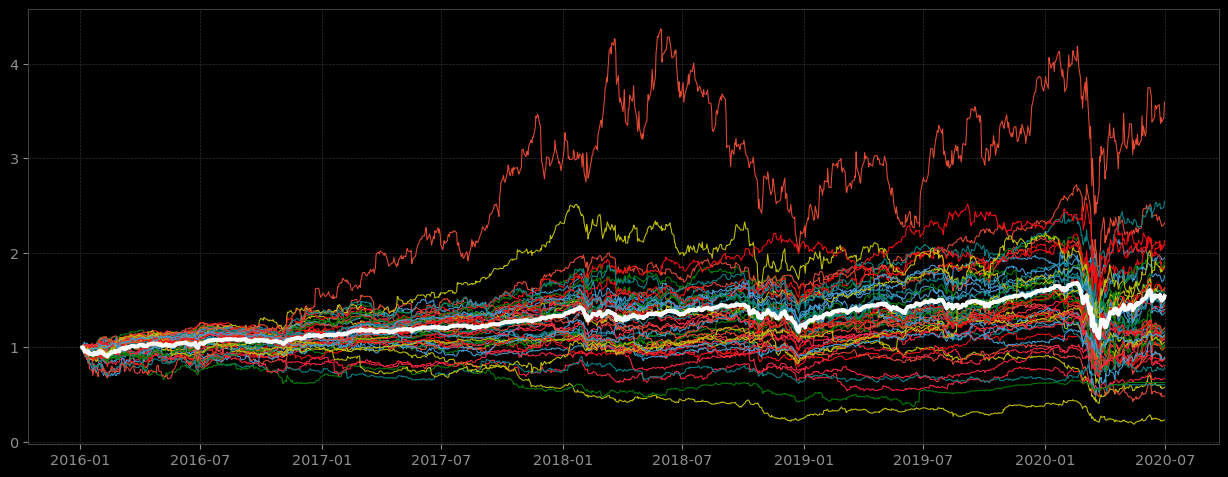

In [1166]:
fig(16, 6)
plt.plot(data/data.iloc[0,:]);
plt.plot(RUI/RUI.iloc[0], lw=3, c='w');

In [ ]:
weights = [holdings[holdings.Ticker==k]['Weight (%)'].values[0] for k in holdings.Ticker if k in constituents]
weights

Naive approach

In [ ]:
# first_approx = data.sum(axis=1)
first_approx = (data * weights).sum(axis=1)
plt.plot(first_approx - first_approx[0], label='Naive approx')
plt.plot(RUI - RUI[0], label='RUI'); plt.legend();

# Linear regression model
<hr/>

Split into train and test intervals. Let's take 

In [1150]:
x_train, y_train = data['2016-01-01':'2019-01-01'], RUI['2016-01-01':'2019-01-01']

x_test, y_test = data['2019-01-02':'2020-07-30'], RUI['2019-01-02':'2020-07-30']

## Lasso linear regression

In [ ]:
scores = {}
best_score, best_model, best_alpha = 0, None, 0
for a in np.logspace(-2, 1, 10):
    clf = linear_model.Lasso(alpha=a, fit_intercept=False, max_iter=20000)
    model = clf.fit(x_train, y_train)
    score = model.score(x_train, y_train)
    scores[a] = score
    if score > best_score:
        best_score = score
        best_model = model
        best_alpha = a
        
print(best_model, best_score, best_alpha)
plt.plot(pd.Series(scores))

In [ ]:
fig(16, 5)
sbp(12,1); 
plt.plot(best_model.predict(x_train))
plt.plot(y_train.values); plt.title('Train interval: %f' % best_model.score(x_train, y_train))

sbp(12,2); 
plt.plot(pd.Series(best_model.predict(x_test), index=x_test.index))
plt.plot(y_test); plt.title('Test interval: %f' % best_model.score(x_test, y_test));

## Raw linear regression

$$
    C_{index}(t) = \beta + \sum_{k=1}^{N} \alpha_k C_{k}(t) + \varepsilon(t)
$$

In [ ]:
lr_clf = linear_model.LinearRegression(fit_intercept=False)
lr_model = clf.fit(x_train, y_train)
score = lr_model.score(x_train, y_train)

fig(16, 5)
sbp(12,1); 
plt.plot(best_model.predict(x_train))
plt.plot(y_train.values); plt.title('Train interval: %f' % score)

sbp(12,2); plt.plot(pd.Series(lr_model.predict(x_test), index=x_test.index))
plt.plot(y_test); plt.title('Test interval: %f' % lr_model.score(x_test, y_test))

# Kalman Filter for estimating regression model
<hr/>

In [1167]:
b, err, evars = kalman_regression_estimator(x_train.values, y_train.values, 1e-3, 1, intercept=False)

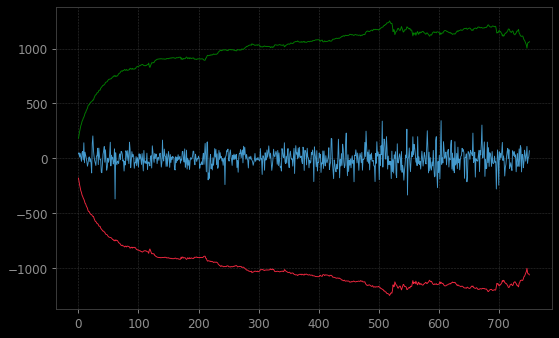

In [1168]:
plt.plot(err[2:])
plt.plot(np.sqrt(evars[2:]))
plt.plot(-np.sqrt(evars[2:]))

The state estimate depends on the choice of parameter matrices F, H, Q and R.

These can be estimated by maximizing the Gaussian log likelihood function.

$$
\mathscr{L} = -\frac{1}{2} (N \ln(2\pi) + \ln(\sigma) + \frac{\varepsilon^2}{\sigma})
$$
N - number of observations

In [ ]:
pmts = permutate_params({
    'vb': list(np.logspace(-5, 2, 10)),
    'vm': list(np.logspace(-5, 2, 10)),
})

N = len(x_train)
ll_max, best = -np.inf, None
for p in pmts:
    b, err, ev = kalman_regression_estimator(x_train.values, y_train.values, **p, intercept=False)
    
    err = err[50:]
    ev = ev[50:]
    ll = -0.5*(N * np.log(2*np.pi) + np.log(ev) + err**2/ev).sum()
    if ll > ll_max:
        ll_max = ll
        best = p
best

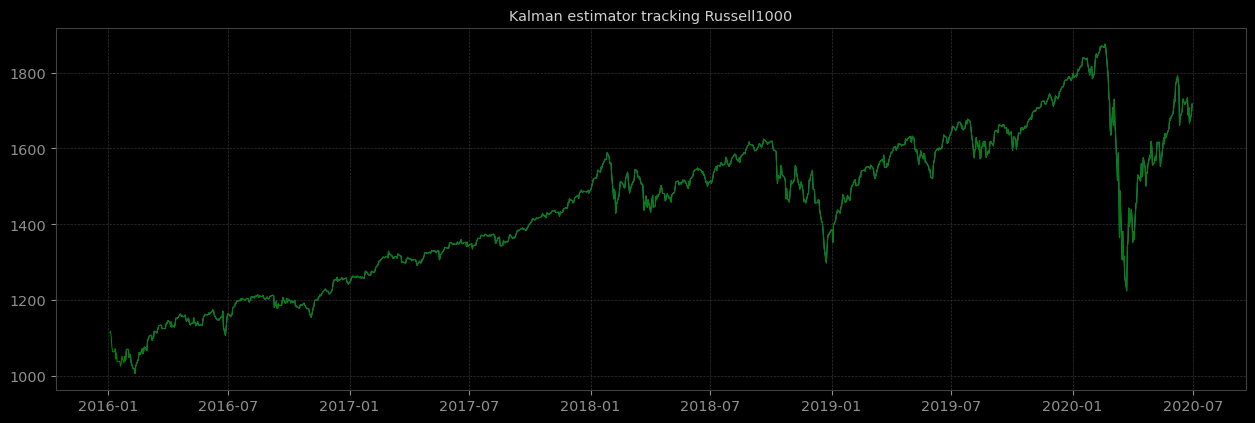

In [1169]:
b, err, evars = kalman_regression_estimator(data.values, RUI.values, **best, intercept=False)
cut_off = slice(15, None)
e_s = pd.Series(err, index=data.index)[cut_off]
v_s = pd.Series(np.sqrt(evars), index=data.index)[cut_off]
b_a = pd.DataFrame(b.T, index=data.index, columns=constituents)[cut_off]
b_a_w = b_a.div(b_a.sum(axis=1), axis=0)

fig(16, 5)
plt.plot(pd.DataFrame(data.values * b.T, index=data.index)[cut_off].sum(axis=1))
plt.plot(RUI, 'g'); plt.title('Kalman estimator tracking Russell1000');

## <font color='green'> Trading model based on tracking error </font>

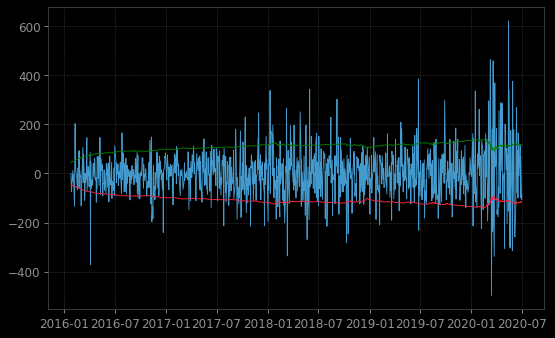

In [1170]:
plt.plot(e_s)
plt.plot(1*v_s); plt.plot(-1*v_s)

In [1125]:
# zscore
z = e_s / v_s

In [ ]:
fig(16, 4)
cmp_to_norm(z)

In [ ]:
g = LookingGlass([z, 1, 0.75, -1, -0.75], {})
fig(16, 6)
g.look()

<font color='red'> <b> Trading model (statistical arbitrage) </b> </font>

In [1171]:
Z_entry, Z_exit = 1, 0.75

#  1 -> take position on weighted portfolio
shorts, longs = z >= Z_entry, z <= -Z_entry
shorts_exits, longs_exits = ((z <= -Z_exit) & (z > -Z_entry)), ((z >= Z_exit) & (z < Z_entry))

signals = pd.concat((
     b_a_w[longs],  b_a_w[longs_exits] * 0, 
    -b_a_w[shorts], b_a_w[shorts_exits] * 0,
), axis=0).sort_index()

# 2 -> take opposite position on Index
signals['RUI'] = 0
signals.loc[longs, 'RUI'] = -1
signals.loc[shorts, 'RUI'] = +1

# we will trade 1000 shares per stock and execute on daily close
signals = shift_signals(np.floor(1000 * signals), hours=15, minutes=59)

In [ ]:
signals

<font color='orange'> <b> Run signals on simulator </b> </font>

Statistic,Model
Gain (USD):,548941.86
CAGR (%):,10.425
Sharpe:,0.723
Sortino:,1.131
Calmar:,0.486
MaxDD (%):,21.460
MaxDD On Init BP (%):,38.300
MaxDD (USD):,383002.665
MaxDD days:,440 days
MaxDD start:,2019-01-03

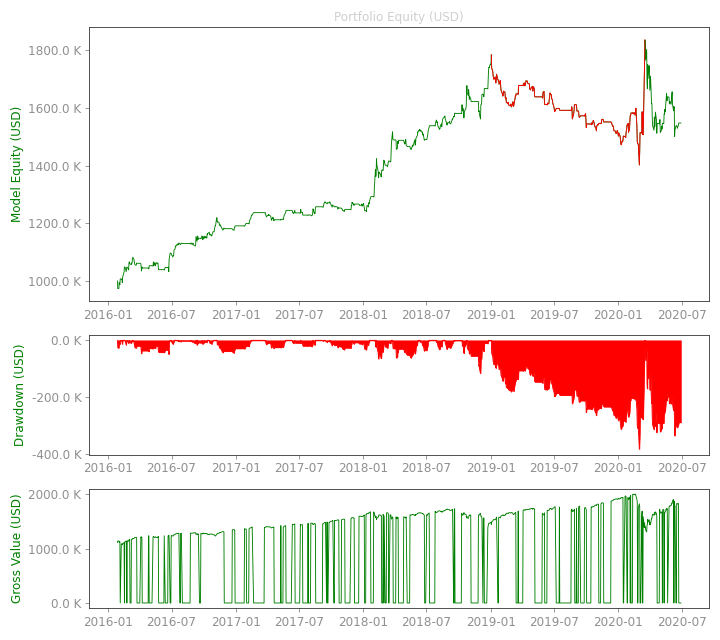

<Figure size 720x640 with 0 Axes>

In [1173]:
p = z_test_signals_inplace(signals, dsrc, 'stock', spread=0.5, verbose=False)
tearsheet(p, 1000000)

# <font color='orange'>Error tracking for all methods</font>
<hr/>

In [1130]:
prd1 = best_model.predict(data)
prd2 = lr_model.predict(data)

In [ ]:
fig(16, 5)
plt.plot(e_s, label='Kalman', lw=1)
plt.plot(prd1 - RUI, label='Linear Lasso', lw=1)
plt.plot(prd2 - RUI, label='Linear', lw=1)
plt.legend();